In [7]:
# import
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import dgamma

# plot settings
font = {'fontname':'Avenir',
        'size':'14'}

plt.rcParams['figure.dpi'] = 500
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

In [3]:
# input gene info
n = 948 # length of pairwise alignment region
nts = 84 # number of transitions
ntv = 6 # number of transversions 

In [4]:
# log-likehood function in Kimura substitution: log f(D|d,k) for D(n_s, n_v)
def kimura(d, k, n = 948, nts = 84, ntv = 6):
  p0 = .25 + .25 * np.exp(-4*d/(k+2)) + .5 * np.exp(-2*d*(k+1)/(k+2))
  p1 = .25 + .25 * np.exp(-4*d/(k+2)) -.5 * np.exp(-2*d*(k+1)/(k+2))
  p2 = .25 - .25 * np.exp(-4*d/(k+2))
  
  return((n - nts - ntv) * np.log(p0/4) +
        nts * np.log(p1/4) + ntv * np.log(p2/4))

In [5]:
# plotting likelihood, prior, and posterior surfaces
dim = 100
dv = np.linspace(0, 0.3, dim)
kv = np.linspace(0, 100, dim)

# basically R expand.grid()
dk = np.array([(x, y) for x in dv for y in kv])


/var/folders/p6/srwyjmkd58z7wrlc0w8mnjbc0000gn/T/ipykernel_22341/570972676.py:8: RuntimeWarning: divide by zero encountered in log
  nts * np.log(p1/4) + ntv * np.log(p2/4))


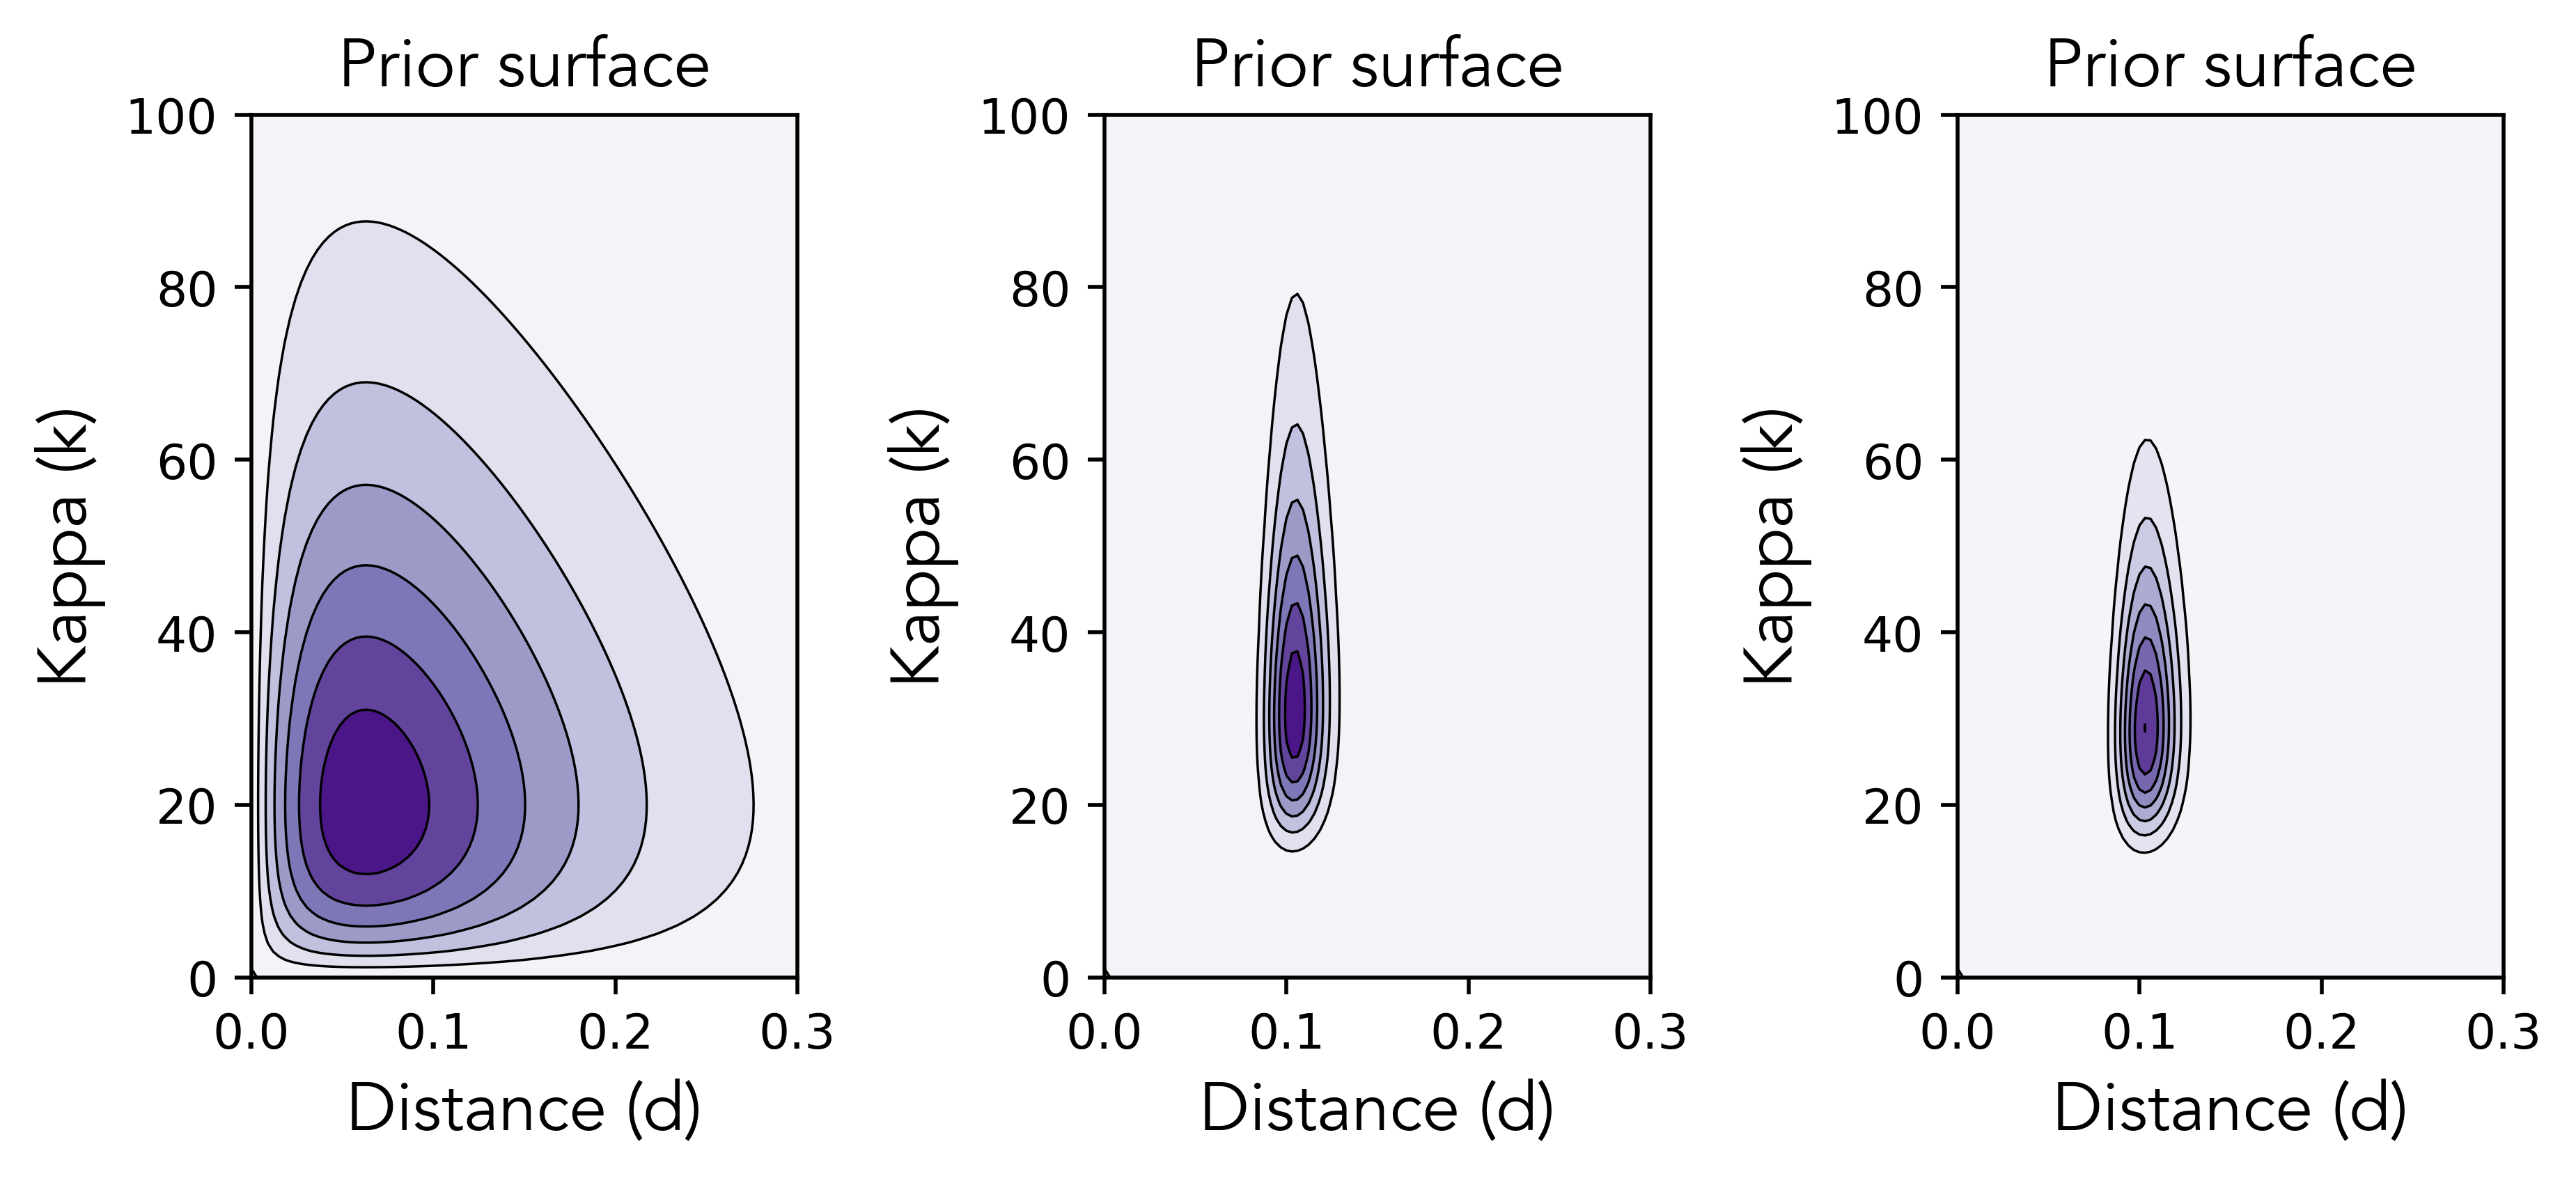

In [9]:
Dv, Kv = np.meshgrid(dv, kv)
pri = np.split(np.array(dgamma.pdf(dk[:,0], 2, scale = 0.06) * dgamma.pdf(dk[:,1], 2, scale = 21)), 100)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# prior surface, f(D) f(k)
ax1.contourf(Dv, Kv, pri, cmap = 'Purples')
ax1.contour(Dv, Kv, pri, colors = 'black', linewidths = 0.5)
ax1.set_title('Prior surface', **font)
ax1.set_xlabel('Distance (d)', **font)
ax1.set_ylabel('Kappa (k)', **font)


dkd = dk[:, 0]
dkk = dk[:, 1]
lnL = kimura(d = dkd, k = dkk)
L = np.hsplit(np.exp(lnL - max(lnL)), 100) # scale likelihood

# likelihood surface, f(D|d, k)
ax2.contourf(Dv, Kv, np.transpose(L), cmap = 'Purples') # np.transpose() is equivalent to (X, Y, -Z) in R ?
ax2.contour(Dv, Kv, np.transpose(L), colors = 'black', linewidths = 0.5)
ax2.set_title('Prior surface', **font)
ax2.set_xlabel('Distance (d)', **font)
ax2.set_ylabel('Kappa (k)', **font)
plt.xlim()


# unscaled posterior surface f(d)f(k)f(D|d, k)
pos = np.multiply(pri, L)

ax3.contourf(Dv, Kv, np.transpose(pos), cmap = 'Purples')
ax3.contour(Dv, Kv, np.transpose(pos), colors = 'black', linewidths = 0.5)
ax3.set_title('Prior surface', **font)
ax3.set_xlabel('Distance (d)', **font)
ax3.set_ylabel('Kappa (k)', **font)
plt.xlim()

plt.show()

In [10]:
# logarithm of the unscaled posterior: f(D) * f(k) * f(D|d, k) 
def logpri(d, k, n=948, ns=84, nv=6, ad=2, bd=20, ak=2, bk=.1):
    lnpriord = (ad - 1) * np.log(d) - bd * d
    lnpriork = (ak - 1) * np.log(k) - bk * k
    
    # log-likelihood model
    expd1 = np.exp(-4 * d / (k + 2))
    expd2 = np.exp(-2 * d * (k + 1)/(k + 2))
    p0 = .25 + .25 * expd1 + .5 * expd2
    p1 = .25 + .25 * expd1 - .5 * expd2
    p2 = .25 - .25 * expd1
    lnL = ((n - nts - ntv) * np.log(p0 / 4) + nts * np.log(p1 / 4) + nv * np.log(p2 / 4))
    
    # return unnormalised posterior
    return(lnpriord + lnpriork + lnL)
    

In [15]:
def mcmcf(initd, initk, N, wd, wk):
    # initd, initk = initial states, N = number of MCMC iterations, 
    # wd = sliding window width of d, wk = sliding window width of k
    
    sampled, samplek = int(N + 1)
    
    # STEP 1: initialise the MCMC chain
    d = initd; sampled[1] = initd
    k = initk; samplek[1] = initk
    ulogpri = logpri(d, k)
    accd = 0; acck = 0 # number of acceptances
    
    # STEP 2: propose new state d*
    for i in range(1, N):
        dprop = d + np.random.uniform(-wd/2, wd/2, 1)
        if (dprop <0): dprop = -dprop
        
        ulogPprop = ulogpri(dprop, k)
        lnalpha = ulogPprop - ulogpri
        
        # STEP 3: accept or reject the proposal if ru < alpha accept proposed d*
        if (lnalpha > 0 | np.random.uniform(1) < np.exp(lnalpha)):
            d = dprop ; logpri = ulogPprop
            accd = accd + 1
        
        # STEP 4: repeat steps 2-3 for k
        kprop = k + np.random.uniform(-wk/2, wk/2, 1)
        if (kprop <0): kprop = -kprop
        
        ulogPprop = ulogpri(d, kprop)
        lnalpha = ulogPprop - ulogpri
        
        # STEP 5: accept or reject the proposal if ru < alpha accept proposed k*
        if (lnalpha > 0 | np.random.uniform(1) < np.exp(lnalpha)):
            k = kprop ; logpri = ulogPprop
            acck = acck + 1
            
        # STEP 6: save chain state
        sampled[i + 1] = d; samplek[i + 1] = k

# return the vector of d and k visited during the mcmc
    return(list(d = sampled, k = samplek))


In [16]:
# run the function
dkmcmc = mcmcf(0.2, 20, 1e4, .12, 180)

TypeError: cannot unpack non-iterable int object